# Time Series Prediction with LSTM Using PyTorch

This kernel is based on *datasets* from

[Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)


## Load Dataset

In [ ]:
# To be run if the files are in your computer

import pandas as pd
import numpy as np

# drive_path = 'drive/My Drive/Colab Notebooks/WP_Datasets_Normalized/'
# Cebrina's   Path: C:\Users\cebri\Documents\Wind Power Estimation\Data
# Guillermo's Path: C:\DTU\\02456 - Deep Learning\Project\Datasets
# Tomi's      Path: C:\Users\PC\Documents\GitHub\WindPower_Estimation

dataPath = r'C:\DTU\\02456 - Deep Learning\Project\Datasets'

dataset_train_1 = pd.read_csv(dataPath+'\Case1\Dataset_Train_1_new.csv', )
dataset_test_1 = pd.read_csv(dataPath+'\Case1\Dataset_Test_1_new.csv')

dataset_train_1.head()

FileNotFoundError: ignored

In [ ]:
# To be run if the files are in Google Colab

import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

drive_path = 'drive/My Drive/Colab Notebooks/WP_Datasets_Normalized/'

dataset_train_1 = pd.read_csv(drive_path+'Dataset_Train_1_new.csv')
dataset_test_1 = pd.read_csv(drive_path+'Dataset_Test_1_new.csv')

dataset_train_1.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Date_Time,Direction_10m,Speed_10m,Temperature_10m,Pressure_seaLevel,Air_Density_10m,Direction_50m,Speed_50m,Temperature_50m,Air_Density_50m,Direction_100m,Speed_100m,Temperature_100m,Air_Density_100m,Direction_150m,Speed_150m,Temperature_150m,Air_Density_150m,Park_Power_[KW]
0,2017-01-07 20:15:00,0.476323,0.110000,0.218502,0.782227,0.752212,0.473538,0.127679,0.218502,0.752212,0.484680,0.047716,0.218502,0.752212,0.515320,0.019504,0.218502,0.752212,0.690394
1,2017-01-07 20:30:00,0.479109,0.116923,0.214832,0.781496,0.755162,0.479109,0.135714,0.214832,0.755162,0.473538,0.053299,0.214832,0.755162,0.459610,0.024823,0.214832,0.755162,0.690394
2,2017-01-07 20:45:00,0.481894,0.127692,0.211009,0.780216,0.758112,0.481894,0.147321,0.211009,0.758112,0.462396,0.061421,0.211009,0.758112,0.431755,0.032624,0.211009,0.758112,0.690394
3,2017-01-07 21:00:00,0.484680,0.140769,0.207187,0.778387,0.764012,0.487465,0.161607,0.207187,0.764012,0.459610,0.072589,0.207187,0.764012,0.417827,0.042908,0.207187,0.764012,0.690394
4,2017-01-07 21:15:00,0.487465,0.155385,0.203364,0.776376,0.766962,0.490251,0.178571,0.203364,0.766962,0.456825,0.084772,0.203364,0.766962,0.412256,0.054610,0.203364,0.766962,0.690394


## Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## Data Plot

In [ ]:
training_set_x = dataset_train_1[['Speed_50m','Speed_100m','Direction_50m','Direction_100m']]
training_set_y = dataset_train_1[['Park_Power_[KW]']]

test_set_x = dataset_test_1[['Speed_50m','Speed_100m','Direction_50m','Direction_100m']]
test_set_y = dataset_test_1[['Park_Power_[KW]']]

#Transforming to normal arrays
training_set_x = training_set_x.values
test_set_x = test_set_x.values

training_set_y = training_set_y.values
test_set_y = test_set_y.values

## Dataloading

In [ ]:
# Checking if CUDA (GPU) is available

cuda_available = torch.cuda.is_available()
print("Running GPU.") if cuda_available else print("No GPU available.")

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if cuda_available:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if cuda_available:
        return x.cpu().data.numpy()
    return x.data.numpy()

# Empty CUDA cache, just in case
import gc
gc.collect()
torch.cuda.empty_cache()

Running GPU.


In [ ]:
# This function is a manual implementation, similar to other implementations like TimeSeriesData

def sliding_windows(data_x, data_y, seq_length_past, seq_length_future):
    x = []
    y = []

    for i in range(seq_length_past,len(data_x)-seq_length_future+1):
        _x = data_x[(i-seq_length_past):(i+seq_length_future)]
        _y = data_y[i]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

# Length of sequences to be fed into NN is defined here

# seq_length_past = 99 means the last 99 timesteps are included in the sequence
# seq_length_future = 1 means the current timestep is included in the sequence (>1 also includes future timesteps)
seq_length_past = 99
seq_length_future = 1

# Assembling sequences for training set
x, y = sliding_windows(training_set_x, training_set_y, seq_length_past, seq_length_future)

if cuda_available: # Loading sequences into GPU if possible
  torch.cuda.empty_cache()
  trainX = torch.Tensor(np.array(x)).cuda()
  trainY = torch.Tensor(np.array(y)).cuda()
else:
  trainX = torch.Tensor(np.array(x))
  trainY = torch.Tensor(np.array(y))

# Assembling sequences for test set
x, y = sliding_windows(test_set_x, test_set_y, seq_length_past, seq_length_future)

if cuda_available: # Loading sequences into GPU if possible
  torch.cuda.empty_cache()
  testX = torch.Tensor(np.array(x)).cuda()
  testY = torch.Tensor(np.array(y)).cuda()
else:
  testX = torch.Tensor(np.array(x))
  testY = torch.Tensor(np.array(y))

## Model

In [ ]:
# Definition of the network
# Maybe a name like "Net" instead of "LSTM" would be more appropriate

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        if cuda_available:
          h_0 = Variable(torch.zeros(
              self.num_layers, x.size(0), self.hidden_size).cuda())
          c_0 = Variable(torch.zeros(
              self.num_layers, x.size(0), self.hidden_size).cuda())
        else:
          h_0 = Variable(torch.zeros(
              self.num_layers, x.size(0), self.hidden_size))
          c_0 = Variable(torch.zeros(
              self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)
        out = self.sigmoid(out)

        return out

In [ ]:
# Defining training settings

num_epochs = 150
learning_rate = 1e-3
batch_size = 1000

input_size = trainX.shape[2]    #number of features
hidden_size = 20                #number of hidden units
num_layers = 1                  #number of LSTM layers

num_classes = 1

if cuda_available:
  lstm = LSTM(num_classes, input_size, hidden_size, num_layers).cuda()
else:
  lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

# Using MSE Loss and Adam, as all papers using LSTM seem to use this
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Moving sequences into data loader

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

train_loader = DataLoader(dataset=TensorDataset(trainX,trainY),batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=TensorDataset(testX,testY),batch_size=batch_size,shuffle=False)

In [ ]:
# Training the model
train_losses_plot = []
test_losses_plot = []

for epoch in range(num_epochs+1):
    train_losses = []
    test_losses = []

    lstm.train()
    for x_batch, y_batch in train_loader:
        outputs = lstm(x_batch)

        # obtain the loss function
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    ### Validate on test set
    lstm.eval()
    for x_batch, y_batch in test_loader:
        outputs = lstm(x_batch)

        # obtain the loss function
        loss = criterion(outputs, y_batch)
        test_losses.append(loss.item())

    train_losses_plot.append(np.mean(train_losses))
    test_losses_plot.append(np.mean(test_losses))

    if epoch % 50 == 0:   # Reporting results from time to time to track learning progress
        print("Epoch: %d, training loss: %1.5f, validation loss: %1.5f" % (epoch, np.mean(train_losses), np.mean(test_losses)))

Epoch: 0, training loss: 0.08259, validation loss: 0.06089
Epoch: 50, training loss: 0.03683, validation loss: 0.03259
Epoch: 100, training loss: 0.03405, validation loss: 0.03553
Epoch: 150, training loss: 0.03256, validation loss: 0.03414


(0.0, 150.0)

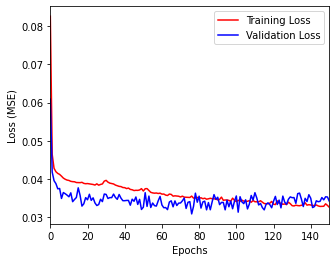

In [ ]:
epoch = np.arange(len(train_losses_plot))
plt.figure(figsize=(5, 4))
plt.plot(epoch, train_losses_plot, 'r', epoch, test_losses_plot, 'b')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.xlim(0,150)
#plt.rcParams["figure.figsize"] = (3,3)

## Testing for Park Power values

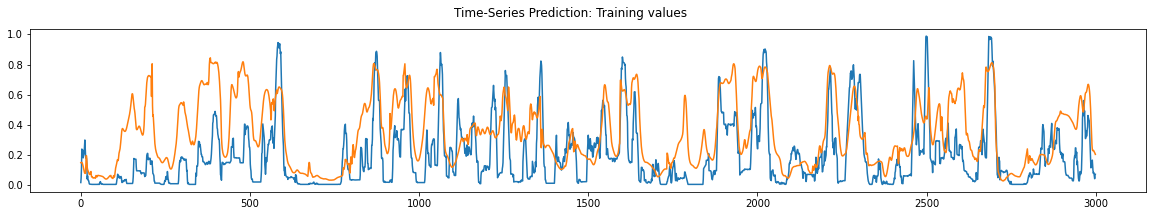

Loss:  0.03267458159343793


In [ ]:
# Plotting fitted training values

lstm.eval()
train_predict = lstm(trainX) #Plotting only a subsection to better appreciate the results
if cuda_available:
  train_predict = train_predict.cpu()

# Calculating loss of fitted training data
loss = criterion(train_predict[:,0], torch.tensor(training_set_y[:,0][seq_length_past:]))

train_predict = train_predict.data.numpy()
#train_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,np.transpose([np.transpose(train_predict)])))
train_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,train_predict))

# Set here the start and end index of data in order to zoom in
start_index = 2000
end_index = 5000

dataY_plot = training_set_y[start_index:end_index]
data_predict = train_predict[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(dataY_plot)
plt.plot(data_predict)

# Uncommenting the below will also plot Speeds and Directions to compare with already plotted curves
#for i in range(input_size):
#  plt.plot(np.transpose([np.transpose(training_set_x[:,i])])[start_index:end_index],',')

plt.suptitle('Time-Series Prediction: Training values')
plt.show()

# Printing loss below the plot
print('Loss: ',loss.item())

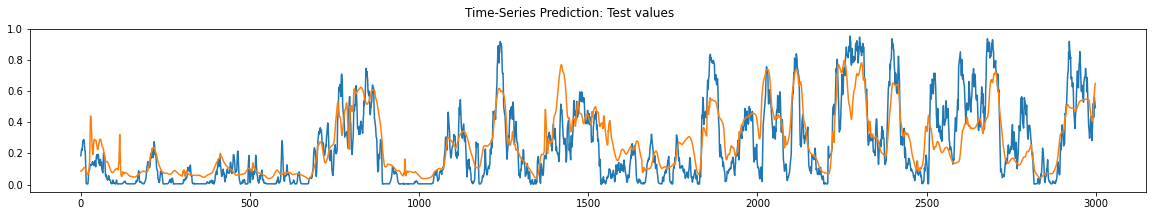

Loss:  0.03296692505117126


In [ ]:
# Plotting predicted test values

lstm.eval()
test_predict = lstm(testX) #Plotting only a subsection to better appreciate the results
if cuda_available:
  test_predict = test_predict.cpu()

# Calculating loss of predicted test data
loss = criterion(test_predict[:,0], torch.tensor(test_set_y[:,0][seq_length_past:]))

test_predict = test_predict.data.numpy()
#train_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,np.transpose([np.transpose(train_predict)])))
test_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,test_predict))

# Set here the start and end index of data in order to zoom in
start_index = 12000
end_index = 15000

dataY_plot = test_set_y[start_index:end_index]
data_predict = test_predict[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(dataY_plot)
plt.plot(data_predict)

# Uncommenting the below will also plot Speeds and Directions to compare with already plotted curves
#for i in range(input_size):
#  plt.plot(np.transpose([np.transpose(test_set_x[:,i])])[start_index:end_index],',')

plt.suptitle('Time-Series Prediction: Test values')
plt.show()

# Printing loss below the plot
print('Loss: ',loss.item())

## Measurements

In [ ]:
# To be run if the files are in your computer

# drive_path = 'drive/My Drive/Colab Notebooks/WP_Datasets_Normalized/'
# Cebrina's   Path: C:\Users\cebri\Documents\Wind Power Estimation\Data
# Guillermo's Path: C:\DTU\\02456 - Deep Learning\Project\Datasets
# Tomi's      Path: C:\Users\PC\Documents\GitHub\WindPower_Estimation

dataPath = r'C:\DTU\\02456 - Deep Learning\Project\Datasets'

dataset_conversions = pd.read_csv(dataPath+'\Case1\Dataset_NormData_1_new.csv', )

dataset_conversions.head()

In [ ]:
# To be run if the files are in Google Colab

drive_path = 'drive/My Drive/Colab Notebooks/WP_Datasets_Normalized/'

dataset_conversions = pd.read_csv(drive_path+'Dataset_NormData_1_new.csv')

dataset_conversions.head()

,Type,Direction_10m,Speed_10m,Temperature_10m,Pressure_seaLevel,Air_Density_10m,Direction_50m,Speed_50m,Temperature_50m,Air_Density_50m,Direction_100m,Speed_100m,Temperature_100m,Air_Density_100m,Direction_150m,Speed_150m,Temperature_150m,Air_Density_150m,Park_Power_[KW]
0,Max,359.0,13.0,34.2,1017.19,1.451,359.0,11.3,34.2,1.451,359.0,19.8,34.2,1.451,359.0,28.3,34.2,1.451,49896.0
1,Min,0.0,0.0,-31.2,962.50,1.112,0.0,0.1,-31.2,1.112,0.0,0.1,-31.2,1.112,0.0,0.1,-31.2,1.112,-229.0


In [ ]:
full_set_x = np.concatenate((training_set_x,test_set_x))
full_set_y = np.concatenate((training_set_y,test_set_y))

# Assembling sequences for full set
x, y = sliding_windows(full_set_x, full_set_y, seq_length_past, seq_length_future)

if cuda_available: # Loading sequences into GPU if possible
  torch.cuda.empty_cache()
  trainX = torch.Tensor(np.array(x)).cuda()
  trainY = torch.Tensor(np.array(y)).cuda()
else:
  trainX = torch.Tensor(np.array(x))
  trainY = torch.Tensor(np.array(y))

In [ ]:
# Predicting test values

lstm.eval()
full_predict = lstm(trainX)
test_predict = full_predict[len(full_predict)-len(test_set_y):]
if cuda_available:
  test_predict = test_predict.cpu()

test_predict = test_predict.data.numpy()
test_values = test_set_y

norm_values_max = dataset_conversions[dataset_conversions['Type'] == 'Max']['Park_Power_[KW]'].squeeze()
norm_values_min = dataset_conversions[dataset_conversions['Type'] == 'Min']['Park_Power_[KW]'].squeeze()

test_predict_real = test_predict*(norm_values_max-norm_values_min) + norm_values_min
test_values_real = test_values*(norm_values_max-norm_values_min) + norm_values_min

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    #return np.mean(np.abs(y_true - y_pred) / ((abs(y_true) + abs(y_pred))/2)) * 100
    return np.mean(np.abs(y_true - y_pred) / ((abs(y_true) + abs(y_pred)))) * 100

def accuracy_rate(y_true, y_pred, cap):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return (1 - (np.sqrt(np.mean((y_true - y_pred) ** 2))/cap)) * 100

cap = 49500

rms = mean_squared_error(test_values_real, test_predict_real, squared=False)
mae = mean_absolute_error(test_values_real, test_predict_real)

#rms_norm = mean_squared_error(test_values, test_predict, squared=False)
#mae_norm = mean_absolute_error(test_values, test_predict)
#mape_norm = mean_absolute_percentage_error(test_values, test_predict)

rms_norm = rms/cap
mae_norm = mae/cap
smape = symmetric_mean_absolute_percentage_error(test_values_real, test_predict_real)
accuracy = accuracy_rate(test_values_real, test_predict_real, cap)

print('rms: ',rms)
print('mae: ',mae)
print('rms (normalized): ',rms_norm)
print('mae (normalized): ',mae_norm)
print('smape: ',smape)
print('accuracy: ',accuracy)

rms:  9101.94152018408
mae:  6716.932099360567
rms (normalized):  0.18387760646836526
mae (normalized):  0.13569559796688013
smape:  39.88537218552873
accuracy:  81.61223935316347


## Training on Full Dataset

In [ ]:
full_set_x = np.concatenate((training_set_x,test_set_x))
full_set_y = np.concatenate((training_set_y,test_set_y))

# Assembling sequences for full set
x, y = sliding_windows(full_set_x, full_set_y, seq_length_past, seq_length_future)

if cuda_available: # Loading sequences into GPU if possible
  torch.cuda.empty_cache()
  trainX = torch.Tensor(np.array(x)).cuda()
  trainY = torch.Tensor(np.array(y)).cuda()
else:
  trainX = torch.Tensor(np.array(x))
  trainY = torch.Tensor(np.array(y))

In [ ]:
# Defining training settings

num_epochs = 400
learning_rate = 1e-3
batch_size = 1000

input_size = trainX.shape[2]    #number of features
hidden_size = 20                #number of hidden units
num_layers = 1                  #number of LSTM layers

num_classes = 1

if cuda_available:
  lstm = LSTM(num_classes, input_size, hidden_size, num_layers).cuda()
else:
  lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

# Using MSE Loss and Adam, as all papers using LSTM seem to use this
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Moving sequences into data loader

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

train_loader = DataLoader(dataset=TensorDataset(trainX,trainY),batch_size=batch_size,shuffle=True)

In [ ]:
# Training the model

lstm.train()
for epoch in range(num_epochs+1):
    train_losses = []

    for x_batch, y_batch in train_loader:
        outputs = lstm(x_batch)

        # obtain the loss function
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    if epoch % 50 == 0:   # Reporting results from time to time to track learning progress
        print("Epoch: %d, loss: %1.5f" % (epoch, np.mean(train_losses)))

Epoch: 0, loss: 0.03418
Epoch: 50, loss: 0.03133
Epoch: 100, loss: 0.03524
Epoch: 150, loss: 0.03241
Epoch: 200, loss: 0.03066
Epoch: 250, loss: 0.03479
Epoch: 300, loss: 0.03022
Epoch: 350, loss: 0.03166
Epoch: 400, loss: 0.02877


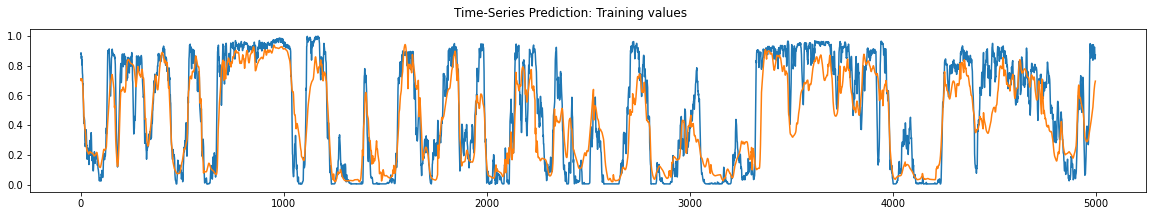

Loss:  0.029384136596276117


In [ ]:
# Plotting fitted training values

lstm.eval()
train_predict = lstm(trainX) #Plotting only a subsection to better appreciate the results
if cuda_available:
  train_predict = train_predict.cpu()

# Calculating loss of fitted training data
loss = criterion(train_predict[:,0], torch.tensor(full_set_y[:,0][seq_length_past:]))

train_predict = train_predict.data.numpy()
#train_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,np.transpose([np.transpose(train_predict)])))
train_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,train_predict))

# Set here the start and end index of data in order to zoom in
start_index = 100000
end_index = 105000

dataY_plot = full_set_y[start_index:end_index]
data_predict = train_predict[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(dataY_plot)
plt.plot(data_predict)

# Uncommenting the below will also plot Speeds and Directions to compare with already plotted curves
#for i in range(input_size):
#  plt.plot(np.transpose([np.transpose(training_set_x[:,i])])[start_index:end_index],',')

plt.suptitle('Time-Series Prediction: Training values')
plt.show()

# Printing loss below the plot
print('Loss: ',loss.item())

## Loading External Test Dataset

In [ ]:
# To be run if the files are in your computer

# drive_path = 'drive/My Drive/Colab Notebooks/WP_Datasets_Normalized/'
# Cebrina's   Path: C:\Users\cebri\Documents\Wind Power Estimation\Data
# Guillermo's Path: C:\DTU\\02456 - Deep Learning\Project\Datasets
# Tomi's      Path: C:\Users\PC\Documents\GitHub\WindPower_Estimation

dataPath = r'C:\DTU\\02456 - Deep Learning\Project\Datasets'

dataset_conversions = pd.read_csv(dataPath+'\Case1\Dataset_NormData_1_new.csv', )

dataset_conversions.head()

In [ ]:
# To be run if the files are in Google Colab

drive_path = 'drive/My Drive/Colab Notebooks/WP_Datasets_Normalized/'

dataset_conversions = pd.read_csv(drive_path+'Dataset_NormData_1_new.csv')

dataset_conversions.head()

,Type,Direction_10m,Speed_10m,Temperature_10m,Pressure_seaLevel,Air_Density_10m,Direction_50m,Speed_50m,Temperature_50m,Air_Density_50m,Direction_100m,Speed_100m,Temperature_100m,Air_Density_100m,Direction_150m,Speed_150m,Temperature_150m,Air_Density_150m,Park_Power_[KW]
0,Max,359.0,13.0,34.2,1017.19,1.451,359.0,11.3,34.2,1.451,359.0,19.8,34.2,1.451,359.0,28.3,34.2,1.451,49896.0
1,Min,0.0,0.0,-31.2,962.50,1.112,0.0,0.1,-31.2,1.112,0.0,0.1,-31.2,1.112,0.0,0.1,-31.2,1.112,-229.0


In [ ]:
# To be run if the files are in your computer

dataset_nwp_day0 = pd.read_csv(dataPath+'\Case1\Day0NWP_C1.csv', )
dataset_nwp_day1 = pd.read_csv(dataPath+'\Case1\Day1NWP_C1.csv', )
dataset_nwp_day2 = pd.read_csv(dataPath+'\Case1\Day2NWP_C1.csv', )
dataset_nwp_day3 = pd.read_csv(dataPath+'\Case1\Day3NWP_C1.csv', )
dataset_nwp_day4 = pd.read_csv(dataPath+'\Case1\Day4NWP_C1.csv', )
dataset_nwp_day5 = pd.read_csv(dataPath+'\Case1\Day5NWP_C1.csv', )
dataset_nwp_day6 = pd.read_csv(dataPath+'\Case1\Day6NWP_C1.csv', )
dataset_nwp_day7 = pd.read_csv(dataPath+'\Case1\Day7NWP_C1.csv', )
dataset_nwp_day8 = pd.read_csv(dataPath+'\Case1\Day8NWP_C1.csv', )
dataset_nwp_day9 = pd.read_csv(dataPath+'\Case1\Day9NWP_C1.csv', )

columns_rename = {'Air Density_10m': 'Air_Density_10m', 'Air Density_50m': 'Air_Density_50m', \
                                'Air Density_100m': 'Air_Density_100m', 'Air Density_150m': 'Air_Density_150m' }

dataset_nwp_day0.rename(columns=columns_rename, inplace=True)
dataset_nwp_day1.rename(columns=columns_rename, inplace=True)
dataset_nwp_day2.rename(columns=columns_rename, inplace=True)
dataset_nwp_day3.rename(columns=columns_rename, inplace=True)
dataset_nwp_day4.rename(columns=columns_rename, inplace=True)
dataset_nwp_day5.rename(columns=columns_rename, inplace=True)
dataset_nwp_day6.rename(columns=columns_rename, inplace=True)
dataset_nwp_day7.rename(columns=columns_rename, inplace=True)
dataset_nwp_day8.rename(columns=columns_rename, inplace=True)
dataset_nwp_day9.rename(columns=columns_rename, inplace=True)
dataset_nwp_day8.head()

In [ ]:
# To be run if the files are in Colab

dataset_nwp_day0 = pd.read_csv(drive_path+'Day0NWP_C1.csv')
dataset_nwp_day1 = pd.read_csv(drive_path+'Day1NWP_C1.csv')
dataset_nwp_day2 = pd.read_csv(drive_path+'Day2NWP_C1.csv')
dataset_nwp_day3 = pd.read_csv(drive_path+'Day3NWP_C1.csv')
dataset_nwp_day4 = pd.read_csv(drive_path+'Day4NWP_C1.csv')
dataset_nwp_day5 = pd.read_csv(drive_path+'Day5NWP_C1.csv')
dataset_nwp_day6 = pd.read_csv(drive_path+'Day6NWP_C1.csv')
dataset_nwp_day7 = pd.read_csv(drive_path+'Day7NWP_C1.csv')
dataset_nwp_day8 = pd.read_csv(drive_path+'Day8NWP_C1.csv')
dataset_nwp_day9 = pd.read_csv(drive_path+'Day9NWP_C1.csv')

columns_rename = {'Air Density_10m': 'Air_Density_10m', 'Air Density_50m': 'Air_Density_50m', \
                                'Air Density_100m': 'Air_Density_100m', 'Air Density_150m': 'Air_Density_150m' }

dataset_nwp_day0.rename(columns=columns_rename, inplace=True)
dataset_nwp_day1.rename(columns=columns_rename, inplace=True)
dataset_nwp_day2.rename(columns=columns_rename, inplace=True)
dataset_nwp_day3.rename(columns=columns_rename, inplace=True)
dataset_nwp_day4.rename(columns=columns_rename, inplace=True)
dataset_nwp_day5.rename(columns=columns_rename, inplace=True)
dataset_nwp_day6.rename(columns=columns_rename, inplace=True)
dataset_nwp_day7.rename(columns=columns_rename, inplace=True)
dataset_nwp_day8.rename(columns=columns_rename, inplace=True)
dataset_nwp_day9.rename(columns=columns_rename, inplace=True)
dataset_nwp_day8.head()

,Date_Time,Direction_10m,Speed_10m,Temperature_10m,Pressure_seaLevel,Air_Density_10m,Direction_50m,Speed_50m,Temperature_50m,Air_Density_50m,Direction_100m,Speed_100m,Temperature_100m,Air_Density_100m,Direction_150m,Speed_150m,Temperature_150m,Air_Density_150m
0,2021-03-29 05:15:00,259,3.07,3.54,972.12,1.225,256,2.14,3.54,1.225,264,6.61,3.54,1.225,266,11.06,3.54,1.225
1,2021-03-29 05:30:00,259,3.30,3.58,972.18,1.225,257,2.35,3.58,1.225,264,6.88,3.58,1.225,266,11.36,3.58,1.225
2,2021-03-29 05:45:00,259,3.57,3.62,972.27,1.225,257,2.60,3.62,1.225,263,7.19,3.62,1.225,265,11.69,3.62,1.225
3,2021-03-29 06:00:00,259,3.88,3.67,972.39,1.224,257,2.90,3.67,1.224,262,7.53,3.67,1.224,264,12.05,3.67,1.224
4,2021-03-29 06:15:00,258,4.21,3.71,972.51,1.224,257,3.22,3.71,1.224,261,7.88,3.71,1.224,262,12.40,3.71,1.224


In [ ]:
set_columns = ['Direction_10m','Speed_10m','Temperature_10m','Pressure_seaLevel', \
                'Air_Density_10m','Direction_50m','Speed_50m','Temperature_50m','Air_Density_50m', \
                'Direction_100m','Speed_100m','Temperature_100m','Air_Density_100m','Direction_150m','Speed_150m', \
                'Temperature_150m','Air_Density_150m']

# Loading normalization values

norm_values_max = pd.DataFrame(columns=set_columns)
norm_values_min = pd.DataFrame(columns=set_columns)

for column in set_columns:
    norm_values_max[column] = dataset_conversions[dataset_conversions['Type'] == 'Max'][column]
    norm_values_min[column] = dataset_conversions[dataset_conversions['Type'] == 'Min'][column]

for column in set_columns:
    maxvalue = norm_values_max[column].squeeze()
    minvalue = norm_values_min[column].squeeze()
    dataset_nwp_day0[column] = (dataset_nwp_day0[column]-minvalue)/(maxvalue-minvalue)
    dataset_nwp_day1[column] = (dataset_nwp_day1[column]-minvalue)/(maxvalue-minvalue)
    dataset_nwp_day2[column] = (dataset_nwp_day2[column]-minvalue)/(maxvalue-minvalue)
    dataset_nwp_day3[column] = (dataset_nwp_day3[column]-minvalue)/(maxvalue-minvalue)
    dataset_nwp_day4[column] = (dataset_nwp_day4[column]-minvalue)/(maxvalue-minvalue)
    dataset_nwp_day5[column] = (dataset_nwp_day5[column]-minvalue)/(maxvalue-minvalue)
    dataset_nwp_day6[column] = (dataset_nwp_day6[column]-minvalue)/(maxvalue-minvalue)
    dataset_nwp_day7[column] = (dataset_nwp_day7[column]-minvalue)/(maxvalue-minvalue)
    dataset_nwp_day8[column] = (dataset_nwp_day8[column]-minvalue)/(maxvalue-minvalue)
    dataset_nwp_day9[column] = (dataset_nwp_day9[column]-minvalue)/(maxvalue-minvalue)

dataset_nwp_day8.head()

,Date_Time,Direction_10m,Speed_10m,Temperature_10m,Pressure_seaLevel,Air_Density_10m,Direction_50m,Speed_50m,Temperature_50m,Air_Density_50m,Direction_100m,Speed_100m,Temperature_100m,Air_Density_100m,Direction_150m,Speed_150m,Temperature_150m,Air_Density_150m
0,2021-03-29 05:15:00,0.721448,0.236154,0.531193,0.175901,0.333333,0.713092,0.182143,0.531193,0.333333,0.735376,0.330457,0.531193,0.333333,0.740947,0.388652,0.531193,0.333333
1,2021-03-29 05:30:00,0.721448,0.253846,0.531804,0.176998,0.333333,0.715877,0.200893,0.531804,0.333333,0.735376,0.344162,0.531804,0.333333,0.740947,0.399291,0.531804,0.333333
2,2021-03-29 05:45:00,0.721448,0.274615,0.532416,0.178643,0.333333,0.715877,0.223214,0.532416,0.333333,0.732591,0.359898,0.532416,0.333333,0.738162,0.410993,0.532416,0.333333
3,2021-03-29 06:00:00,0.721448,0.298462,0.533180,0.180837,0.330383,0.715877,0.250000,0.533180,0.330383,0.729805,0.377157,0.533180,0.330383,0.735376,0.423759,0.533180,0.330383
4,2021-03-29 06:15:00,0.718663,0.323846,0.533792,0.183032,0.330383,0.715877,0.278571,0.533792,0.330383,0.727019,0.394924,0.533792,0.330383,0.729805,0.436170,0.533792,0.330383


In [ ]:
# Adding External Set Day 0 to the full dataset

ext_test_set_x = dataset_nwp_day0[['Speed_50m','Speed_100m','Direction_50m','Direction_100m']]
ext_test_set_x = ext_test_set_x.values
len_external = len(ext_test_set_x)

full_set_x = np.concatenate((full_set_x,ext_test_set_x))
dummy_set_y = np.zeros(shape=full_set_x.shape)

# Assembling sequences for full set
x, y = sliding_windows(full_set_x, dummy_set_y, seq_length_past, seq_length_future)

if cuda_available: # Loading sequences into GPU if possible
  torch.cuda.empty_cache()
  testX = torch.Tensor(np.array(x)).cuda()
  testY = torch.Tensor(np.array(y)).cuda()
else:
  testX = torch.Tensor(np.array(x))
  testY = torch.Tensor(np.array(y))

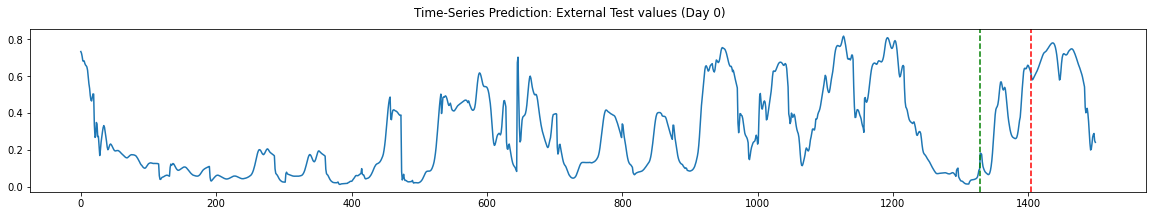

In [ ]:
# Plotting predicted test values including Day 0

lstm.eval()
test_predict = lstm(testX) #Plotting only a subsection to better appreciate the results
if cuda_available:
  test_predict = test_predict.cpu()

test_predict = test_predict.data.numpy()
#train_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,np.transpose([np.transpose(train_predict)])))
test_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,test_predict))

# Set here the start and end index of data in order to zoom in
start_index = len(test_predict)-1500
end_index = len(test_predict)

data_predict = test_predict[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(data_predict)
plt.axvline(x=(end_index-start_index)-len_external, c='g', linestyle='--')
plt.axvline(x=(end_index-start_index)-96, c='r', linestyle='--')

plt.suptitle('Time-Series Prediction: External Test values (Day 0)')
plt.show()

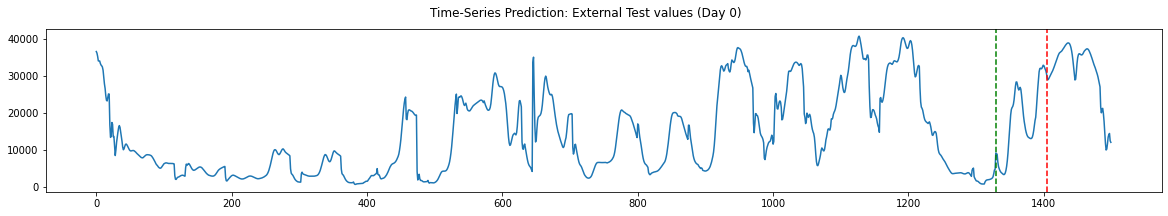

In [ ]:
# Plotting reverse-normalized values for Day 0

norm_values_max = dataset_conversions[dataset_conversions['Type'] == 'Max']['Park_Power_[KW]'].squeeze()
norm_values_min = dataset_conversions[dataset_conversions['Type'] == 'Min']['Park_Power_[KW]'].squeeze()

test_predict_real = test_predict*(norm_values_max-norm_values_min) + norm_values_min

#Plot

# Set here the start and end index of data in order to zoom in
start_index = len(test_predict_real)-1500
end_index = len(test_predict_real)

data_predict = test_predict_real[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(data_predict)
plt.axvline(x=(end_index-start_index)-len(ext_test_set_x), c='g', linestyle='--')
plt.axvline(x=(end_index-start_index)-96, c='r', linestyle='--')

plt.suptitle('Time-Series Prediction: External Test values (Day 0)')
plt.show()

In [ ]:
competition_y = test_predict_real[len(test_predict_real)-96:]
df_competition_y = pd.DataFrame(competition_y)
df_competition_y.tail()

,0
91,13360.195956
92,14070.787931
93,14385.226609
94,12390.767573
95,11977.673367


In [ ]:
#Exporting last 96 predictions for Day 0

df_competition_y.to_csv(drive_path+'WindGurus_Case1_Day0.csv',index=False,header=False)

In [ ]:
# Adding External Set Day 1 to the full dataset

ext_test_set_x = dataset_nwp_day1[['Speed_50m','Speed_100m','Direction_50m','Direction_100m']]
ext_test_set_x = ext_test_set_x.values
len_external = len_external + len(ext_test_set_x)

full_set_x = np.concatenate((full_set_x,ext_test_set_x))
dummy_set_y = np.zeros(shape=full_set_x.shape)

# Assembling sequences for full set
x, y = sliding_windows(full_set_x, dummy_set_y, seq_length_past, seq_length_future)

if cuda_available: # Loading sequences into GPU if possible
  torch.cuda.empty_cache()
  testX = torch.Tensor(np.array(x)).cuda()
  testY = torch.Tensor(np.array(y)).cuda()
else:
  testX = torch.Tensor(np.array(x))
  testY = torch.Tensor(np.array(y))

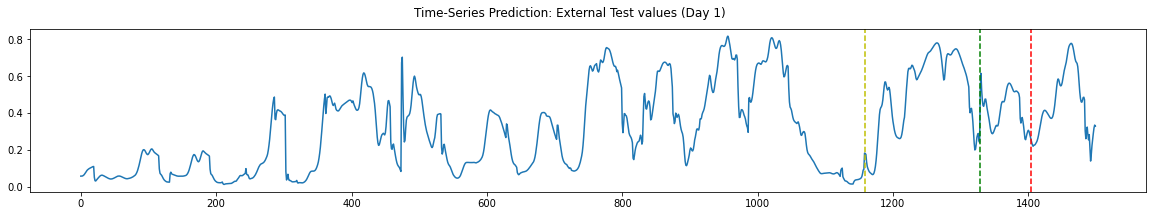

In [ ]:
# Plotting predicted test values including Day 1

lstm.eval()
test_predict = lstm(testX) #Plotting only a subsection to better appreciate the results
if cuda_available:
  test_predict = test_predict.cpu()

test_predict = test_predict.data.numpy()
#train_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,np.transpose([np.transpose(train_predict)])))
test_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,test_predict))

# Set here the start and end index of data in order to zoom in
start_index = len(test_predict)-1500
end_index = len(test_predict)

data_predict = test_predict[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(data_predict)
plt.axvline(x=(end_index-start_index)-len_external, c='y', linestyle='--')
plt.axvline(x=(end_index-start_index)-len(ext_test_set_x), c='g', linestyle='--')
plt.axvline(x=(end_index-start_index)-96, c='r', linestyle='--')

plt.suptitle('Time-Series Prediction: External Test values (Day 1)')
plt.show()

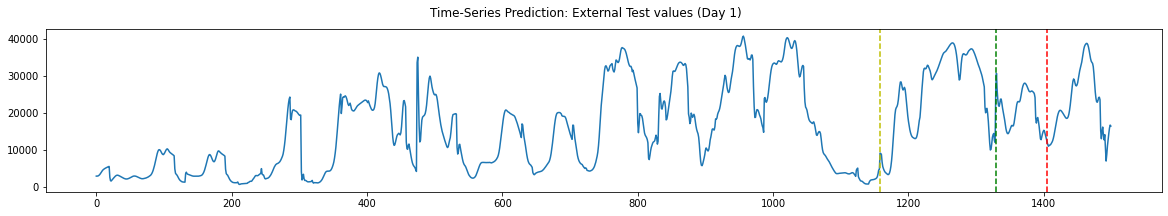

In [ ]:
# Plotting reverse-normalized values for Day 1

norm_values_max = dataset_conversions[dataset_conversions['Type'] == 'Max']['Park_Power_[KW]'].squeeze()
norm_values_min = dataset_conversions[dataset_conversions['Type'] == 'Min']['Park_Power_[KW]'].squeeze()

test_predict_real = test_predict*(norm_values_max-norm_values_min) + norm_values_min

#Plot

# Set here the start and end index of data in order to zoom in
start_index = len(test_predict_real)-1500
end_index = len(test_predict_real)

data_predict = test_predict_real[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(data_predict)
plt.axvline(x=(end_index-start_index)-len_external, c='y', linestyle='--')
plt.axvline(x=(end_index-start_index)-len(ext_test_set_x), c='g', linestyle='--')
plt.axvline(x=(end_index-start_index)-96, c='r', linestyle='--')

plt.suptitle('Time-Series Prediction: External Test values (Day 1)')
plt.show()

In [ ]:
competition_y = test_predict_real[len(test_predict_real)-96:]
df_competition_y = pd.DataFrame(competition_y)
df_competition_y.tail()

,0
91,12799.672300
92,14413.506521
93,15860.496583
94,16654.564416
95,16388.337976


In [ ]:
#Exporting last 96 predictions for Day 1

df_competition_y.to_csv(drive_path+'WindGurus_Case1_Day1.csv',index=False,header=False)

In [ ]:
# Adding External Set Day 2 to the full dataset

ext_test_set_x = dataset_nwp_day2[['Speed_50m','Speed_100m','Direction_50m','Direction_100m']]
ext_test_set_x = ext_test_set_x.values
len_external = len_external + len(ext_test_set_x)

full_set_x = np.concatenate((full_set_x,ext_test_set_x))
dummy_set_y = np.zeros(shape=full_set_x.shape)

# Assembling sequences for full set
x, y = sliding_windows(full_set_x, dummy_set_y, seq_length_past, seq_length_future)

if cuda_available: # Loading sequences into GPU if possible
  torch.cuda.empty_cache()
  testX = torch.Tensor(np.array(x)).cuda()
  testY = torch.Tensor(np.array(y)).cuda()
else:
  testX = torch.Tensor(np.array(x))
  testY = torch.Tensor(np.array(y))

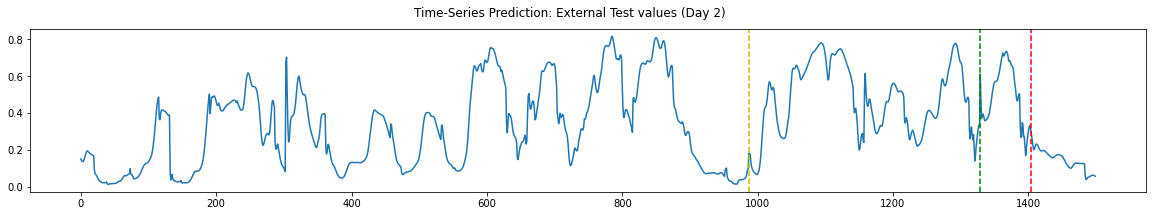

In [ ]:
# Plotting predicted test values including Day 2

lstm.eval()
test_predict = lstm(testX) #Plotting only a subsection to better appreciate the results
if cuda_available:
  test_predict = test_predict.cpu()

test_predict = test_predict.data.numpy()
#train_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,np.transpose([np.transpose(train_predict)])))
test_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,test_predict))

# Set here the start and end index of data in order to zoom in
start_index = len(test_predict)-1500
end_index = len(test_predict)

data_predict = test_predict[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(data_predict)
plt.axvline(x=(end_index-start_index)-len_external, c='y', linestyle='--')
plt.axvline(x=(end_index-start_index)-len(ext_test_set_x), c='g', linestyle='--')
plt.axvline(x=(end_index-start_index)-96, c='r', linestyle='--')

plt.suptitle('Time-Series Prediction: External Test values (Day 2)')
plt.show()

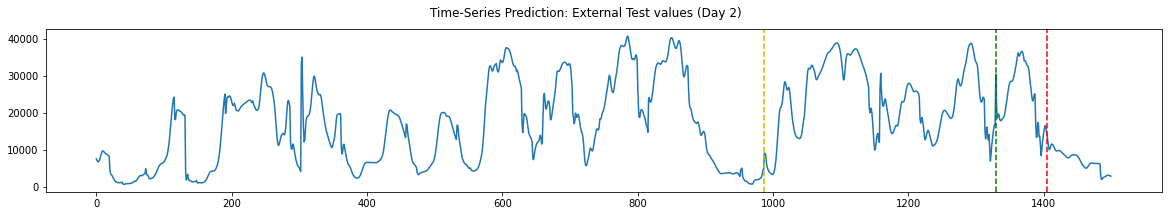

In [ ]:
# Plotting reverse-normalized values for Day 2

norm_values_max = dataset_conversions[dataset_conversions['Type'] == 'Max']['Park_Power_[KW]'].squeeze()
norm_values_min = dataset_conversions[dataset_conversions['Type'] == 'Min']['Park_Power_[KW]'].squeeze()

test_predict_real = test_predict*(norm_values_max-norm_values_min) + norm_values_min

#Plot

# Set here the start and end index of data in order to zoom in
start_index = len(test_predict_real)-1500
end_index = len(test_predict_real)

data_predict = test_predict_real[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(data_predict)
plt.axvline(x=(end_index-start_index)-len_external, c='y', linestyle='--')
plt.axvline(x=(end_index-start_index)-len(ext_test_set_x), c='g', linestyle='--')
plt.axvline(x=(end_index-start_index)-96, c='r', linestyle='--')

plt.suptitle('Time-Series Prediction: External Test values (Day 2)')
plt.show()

In [ ]:
competition_y = test_predict_real[len(test_predict_real)-96:]
df_competition_y = pd.DataFrame(competition_y)
df_competition_y.tail()

,0
91,3077.622815
92,3056.689616
93,2983.037632
94,2896.386241
95,2800.681237


In [ ]:
#Exporting last 96 predictions for Day 2

df_competition_y.to_csv(drive_path+'WindGurus_Case1_Day2.csv',index=False,header=False)

In [ ]:
# Adding External Set Day 3 to the full dataset

ext_test_set_x = dataset_nwp_day3[['Speed_50m','Speed_100m','Direction_50m','Direction_100m']]
ext_test_set_x = ext_test_set_x.values
len_external = len_external + len(ext_test_set_x)

full_set_x = np.concatenate((full_set_x,ext_test_set_x))
dummy_set_y = np.zeros(shape=full_set_x.shape)

# Assembling sequences for full set
x, y = sliding_windows(full_set_x, dummy_set_y, seq_length_past, seq_length_future)

if cuda_available: # Loading sequences into GPU if possible
  torch.cuda.empty_cache()
  testX = torch.Tensor(np.array(x)).cuda()
  testY = torch.Tensor(np.array(y)).cuda()
else:
  testX = torch.Tensor(np.array(x))
  testY = torch.Tensor(np.array(y))

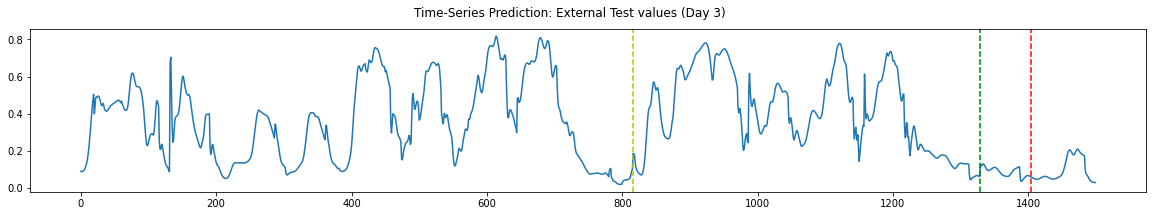

In [ ]:
# Plotting predicted test values including Day 3

lstm.eval()
test_predict = lstm(testX) #Plotting only a subsection to better appreciate the results
if cuda_available:
  test_predict = test_predict.cpu()

test_predict = test_predict.data.numpy()
#train_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,np.transpose([np.transpose(train_predict)])))
test_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,test_predict))

# Set here the start and end index of data in order to zoom in
start_index = len(test_predict)-1500
end_index = len(test_predict)

data_predict = test_predict[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(data_predict)
plt.axvline(x=(end_index-start_index)-len_external, c='y', linestyle='--')
plt.axvline(x=(end_index-start_index)-len(ext_test_set_x), c='g', linestyle='--')
plt.axvline(x=(end_index-start_index)-96, c='r', linestyle='--')

plt.suptitle('Time-Series Prediction: External Test values (Day 3)')
plt.show()

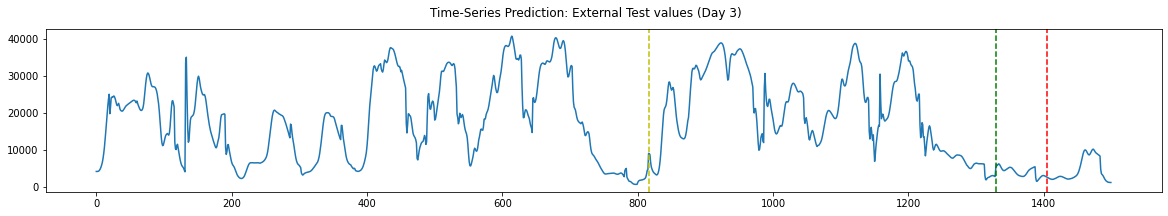

In [ ]:
# Plotting reverse-normalized values for Day 3

norm_values_max = dataset_conversions[dataset_conversions['Type'] == 'Max']['Park_Power_[KW]'].squeeze()
norm_values_min = dataset_conversions[dataset_conversions['Type'] == 'Min']['Park_Power_[KW]'].squeeze()

test_predict_real = test_predict*(norm_values_max-norm_values_min) + norm_values_min

#Plot

# Set here the start and end index of data in order to zoom in
start_index = len(test_predict_real)-1500
end_index = len(test_predict_real)

data_predict = test_predict_real[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(data_predict)
plt.axvline(x=(end_index-start_index)-len_external, c='y', linestyle='--')
plt.axvline(x=(end_index-start_index)-len(ext_test_set_x), c='g', linestyle='--')
plt.axvline(x=(end_index-start_index)-96, c='r', linestyle='--')

plt.suptitle('Time-Series Prediction: External Test values (Day 3)')
plt.show()

In [ ]:
competition_y = test_predict_real[len(test_predict_real)-96:]
df_competition_y = pd.DataFrame(competition_y)
df_competition_y.tail()

,0
91,1269.864545
92,1229.393487
93,1212.692526
94,1200.786330
95,1193.898134


In [ ]:
#Exporting last 96 predictions for Day 3

df_competition_y.to_csv(drive_path+'WindGurus_Case1_Day3.csv',index=False,header=False)

In [ ]:
# Adding External Set Day 4 to the full dataset

ext_test_set_x = dataset_nwp_day4[['Speed_50m','Speed_100m','Direction_50m','Direction_100m']]
ext_test_set_x = ext_test_set_x.values
len_external = len_external + len(ext_test_set_x)

full_set_x = np.concatenate((full_set_x,ext_test_set_x))
dummy_set_y = np.zeros(shape=full_set_x.shape)

# Assembling sequences for full set
x, y = sliding_windows(full_set_x, dummy_set_y, seq_length_past, seq_length_future)

if cuda_available: # Loading sequences into GPU if possible
  torch.cuda.empty_cache()
  testX = torch.Tensor(np.array(x)).cuda()
  testY = torch.Tensor(np.array(y)).cuda()
else:
  testX = torch.Tensor(np.array(x))
  testY = torch.Tensor(np.array(y))

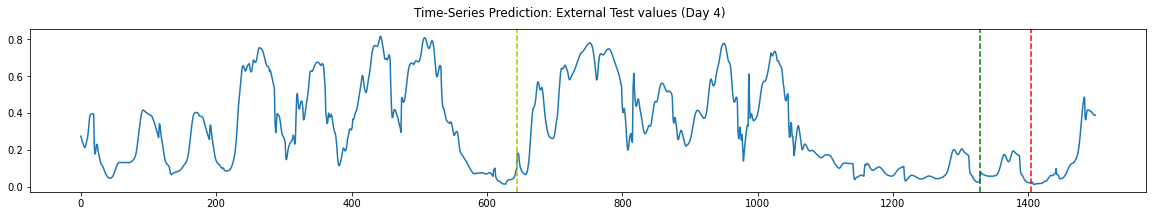

In [ ]:
# Plotting predicted test values including Day 4

lstm.eval()
test_predict = lstm(testX) #Plotting only a subsection to better appreciate the results
if cuda_available:
  test_predict = test_predict.cpu()

test_predict = test_predict.data.numpy()
#train_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,np.transpose([np.transpose(train_predict)])))
test_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,test_predict))

# Set here the start and end index of data in order to zoom in
start_index = len(test_predict)-1500
end_index = len(test_predict)

data_predict = test_predict[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(data_predict)
plt.axvline(x=(end_index-start_index)-len_external, c='y', linestyle='--')
plt.axvline(x=(end_index-start_index)-len(ext_test_set_x), c='g', linestyle='--')
plt.axvline(x=(end_index-start_index)-96, c='r', linestyle='--')

plt.suptitle('Time-Series Prediction: External Test values (Day 4)')
plt.show()

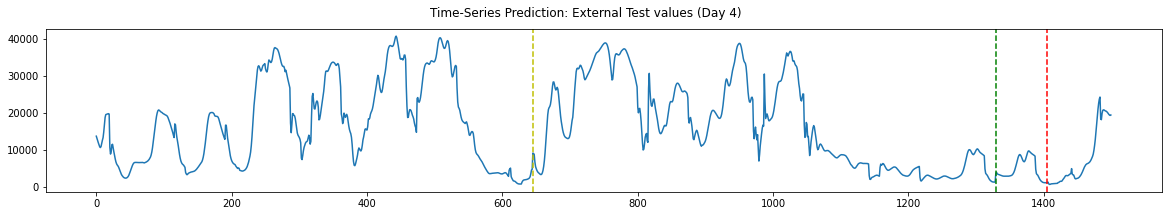

In [ ]:
# Plotting reverse-normalized values for Day 4

norm_values_max = dataset_conversions[dataset_conversions['Type'] == 'Max']['Park_Power_[KW]'].squeeze()
norm_values_min = dataset_conversions[dataset_conversions['Type'] == 'Min']['Park_Power_[KW]'].squeeze()

test_predict_real = test_predict*(norm_values_max-norm_values_min) + norm_values_min

#Plot

# Set here the start and end index of data in order to zoom in
start_index = len(test_predict_real)-1500
end_index = len(test_predict_real)

data_predict = test_predict_real[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(data_predict)
plt.axvline(x=(end_index-start_index)-len_external, c='y', linestyle='--')
plt.axvline(x=(end_index-start_index)-len(ext_test_set_x), c='g', linestyle='--')
plt.axvline(x=(end_index-start_index)-96, c='r', linestyle='--')

plt.suptitle('Time-Series Prediction: External Test values (Day 4)')
plt.show()

In [ ]:
competition_y = test_predict_real[len(test_predict_real)-96:]
df_competition_y = pd.DataFrame(competition_y)
df_competition_y.tail()

,0
91,19823.716102
92,19572.913574
93,19371.182243
94,19274.581494
95,19392.202085


In [ ]:
#Exporting last 96 predictions for Day 4

df_competition_y.to_csv(drive_path+'WindGurus_Case1_Day4.csv',index=False,header=False)

In [ ]:
# Adding External Set Day 5 to the full dataset

ext_test_set_x = dataset_nwp_day5[['Speed_50m','Speed_100m','Direction_50m','Direction_100m']]
ext_test_set_x = ext_test_set_x.values
len_external = len_external + len(ext_test_set_x)

full_set_x = np.concatenate((full_set_x,ext_test_set_x))
dummy_set_y = np.zeros(shape=full_set_x.shape)

# Assembling sequences for full set
x, y = sliding_windows(full_set_x, dummy_set_y, seq_length_past, seq_length_future)

if cuda_available: # Loading sequences into GPU if possible
  torch.cuda.empty_cache()
  testX = torch.Tensor(np.array(x)).cuda()
  testY = torch.Tensor(np.array(y)).cuda()
else:
  testX = torch.Tensor(np.array(x))
  testY = torch.Tensor(np.array(y))

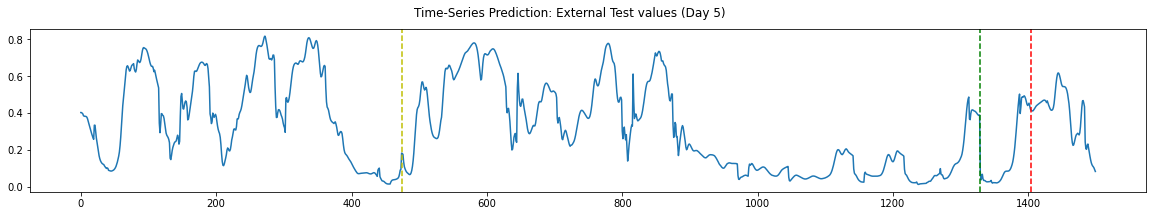

In [ ]:
# Plotting predicted test values including Day 5

lstm.eval()
test_predict = lstm(testX) #Plotting only a subsection to better appreciate the results
if cuda_available:
  test_predict = test_predict.cpu()

test_predict = test_predict.data.numpy()
#train_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,np.transpose([np.transpose(train_predict)])))
test_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,test_predict))

# Set here the start and end index of data in order to zoom in
start_index = len(test_predict)-1500
end_index = len(test_predict)

data_predict = test_predict[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(data_predict)
plt.axvline(x=(end_index-start_index)-len_external, c='y', linestyle='--')
plt.axvline(x=(end_index-start_index)-len(ext_test_set_x), c='g', linestyle='--')
plt.axvline(x=(end_index-start_index)-96, c='r', linestyle='--')

plt.suptitle('Time-Series Prediction: External Test values (Day 5)')
plt.show()

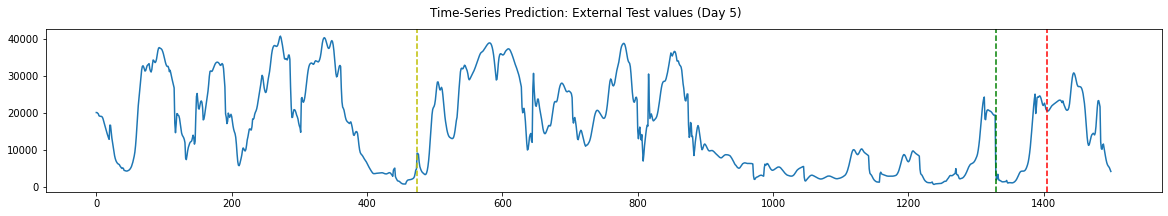

In [ ]:
# Plotting reverse-normalized values for Day 5

norm_values_max = dataset_conversions[dataset_conversions['Type'] == 'Max']['Park_Power_[KW]'].squeeze()
norm_values_min = dataset_conversions[dataset_conversions['Type'] == 'Min']['Park_Power_[KW]'].squeeze()

test_predict_real = test_predict*(norm_values_max-norm_values_min) + norm_values_min

#Plot

# Set here the start and end index of data in order to zoom in
start_index = len(test_predict_real)-1500
end_index = len(test_predict_real)

data_predict = test_predict_real[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(data_predict)
plt.axvline(x=(end_index-start_index)-len_external, c='y', linestyle='--')
plt.axvline(x=(end_index-start_index)-len(ext_test_set_x), c='g', linestyle='--')
plt.axvline(x=(end_index-start_index)-96, c='r', linestyle='--')

plt.suptitle('Time-Series Prediction: External Test values (Day 5)')
plt.show()

In [ ]:
competition_y = test_predict_real[len(test_predict_real)-96:]
df_competition_y = pd.DataFrame(competition_y)
df_competition_y.tail()

,0
91,5584.810051
92,5350.280685
93,5039.101195
94,4588.248280
95,4090.113418


In [ ]:
#Exporting last 96 predictions for Day 5

df_competition_y.to_csv(drive_path+'WindGurus_Case1_Day5.csv',index=False,header=False)

In [ ]:
# Adding External Set Day 6 to the full dataset

ext_test_set_x = dataset_nwp_day6[['Speed_50m','Speed_100m','Direction_50m','Direction_100m']]
ext_test_set_x = ext_test_set_x.values
len_external = len_external + len(ext_test_set_x)

full_set_x = np.concatenate((full_set_x,ext_test_set_x))
dummy_set_y = np.zeros(shape=full_set_x.shape)

# Assembling sequences for full set
x, y = sliding_windows(full_set_x, dummy_set_y, seq_length_past, seq_length_future)

if cuda_available: # Loading sequences into GPU if possible
  torch.cuda.empty_cache()
  testX = torch.Tensor(np.array(x)).cuda()
  testY = torch.Tensor(np.array(y)).cuda()
else:
  testX = torch.Tensor(np.array(x))
  testY = torch.Tensor(np.array(y))

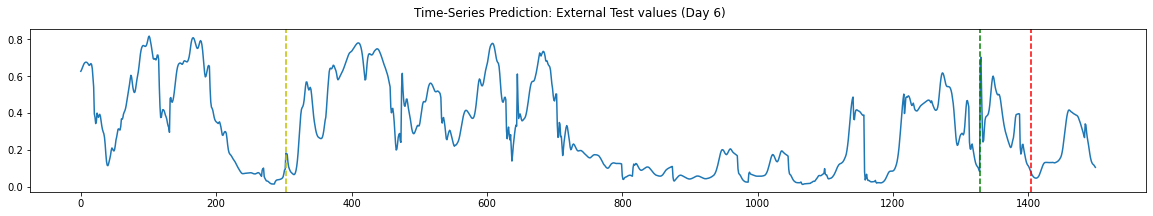

In [ ]:
# Plotting predicted test values including Day 6

lstm.eval()
test_predict = lstm(testX) #Plotting only a subsection to better appreciate the results
if cuda_available:
  test_predict = test_predict.cpu()

test_predict = test_predict.data.numpy()
#train_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,np.transpose([np.transpose(train_predict)])))
test_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,test_predict))

# Set here the start and end index of data in order to zoom in
start_index = len(test_predict)-1500
end_index = len(test_predict)

data_predict = test_predict[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(data_predict)
plt.axvline(x=(end_index-start_index)-len_external, c='y', linestyle='--')
plt.axvline(x=(end_index-start_index)-len(ext_test_set_x), c='g', linestyle='--')
plt.axvline(x=(end_index-start_index)-96, c='r', linestyle='--')

plt.suptitle('Time-Series Prediction: External Test values (Day 6)')
plt.show()

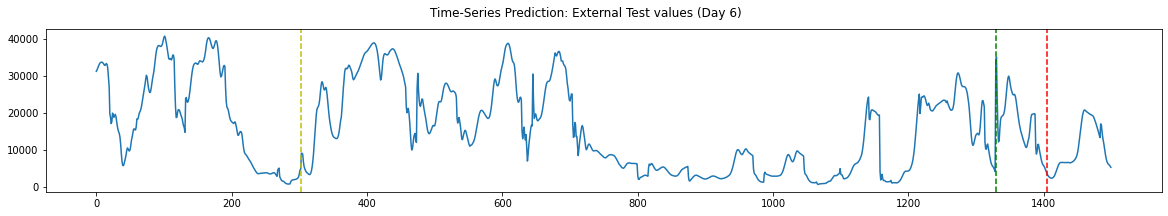

In [ ]:
# Plotting reverse-normalized values for Day 6

norm_values_max = dataset_conversions[dataset_conversions['Type'] == 'Max']['Park_Power_[KW]'].squeeze()
norm_values_min = dataset_conversions[dataset_conversions['Type'] == 'Min']['Park_Power_[KW]'].squeeze()

test_predict_real = test_predict*(norm_values_max-norm_values_min) + norm_values_min

#Plot

# Set here the start and end index of data in order to zoom in
start_index = len(test_predict_real)-1500
end_index = len(test_predict_real)

data_predict = test_predict_real[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(data_predict)
plt.axvline(x=(end_index-start_index)-len_external, c='y', linestyle='--')
plt.axvline(x=(end_index-start_index)-len(ext_test_set_x), c='g', linestyle='--')
plt.axvline(x=(end_index-start_index)-96, c='r', linestyle='--')

plt.suptitle('Time-Series Prediction: External Test values (Day 6)')
plt.show()

In [ ]:
competition_y = test_predict_real[len(test_predict_real)-96:]
df_competition_y = pd.DataFrame(competition_y)
df_competition_y.tail()

,0
91,6132.821664
92,5949.263661
93,5785.275352
94,5518.528308
95,5211.512528


In [ ]:
#Exporting last 96 predictions for Day 6

df_competition_y.to_csv(drive_path+'WindGurus_Case1_Day6.csv',index=False,header=False)

In [ ]:
# Adding External Set Day 7 to the full dataset

ext_test_set_x = dataset_nwp_day7[['Speed_50m','Speed_100m','Direction_50m','Direction_100m']]
ext_test_set_x = ext_test_set_x.values
len_external = len_external + len(ext_test_set_x)

full_set_x = np.concatenate((full_set_x,ext_test_set_x))
dummy_set_y = np.zeros(shape=full_set_x.shape)

# Assembling sequences for full set
x, y = sliding_windows(full_set_x, dummy_set_y, seq_length_past, seq_length_future)

if cuda_available: # Loading sequences into GPU if possible
  torch.cuda.empty_cache()
  testX = torch.Tensor(np.array(x)).cuda()
  testY = torch.Tensor(np.array(y)).cuda()
else:
  testX = torch.Tensor(np.array(x))
  testY = torch.Tensor(np.array(y))

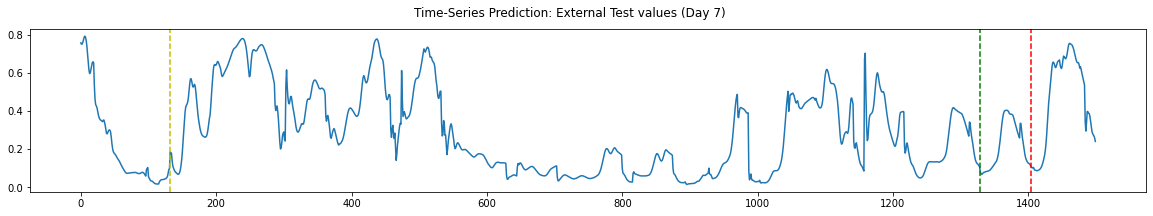

In [ ]:
# Plotting predicted test values including Day 7

lstm.eval()
test_predict = lstm(testX) #Plotting only a subsection to better appreciate the results
if cuda_available:
  test_predict = test_predict.cpu()

test_predict = test_predict.data.numpy()
#train_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,np.transpose([np.transpose(train_predict)])))
test_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,test_predict))

# Set here the start and end index of data in order to zoom in
start_index = len(test_predict)-1500
end_index = len(test_predict)

data_predict = test_predict[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(data_predict)
plt.axvline(x=(end_index-start_index)-len_external, c='y', linestyle='--')
plt.axvline(x=(end_index-start_index)-len(ext_test_set_x), c='g', linestyle='--')
plt.axvline(x=(end_index-start_index)-96, c='r', linestyle='--')

plt.suptitle('Time-Series Prediction: External Test values (Day 7)')
plt.show()

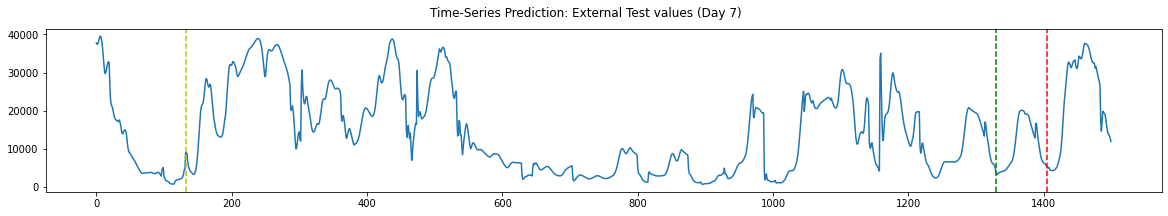

In [ ]:
# Plotting reverse-normalized values for Day 7

norm_values_max = dataset_conversions[dataset_conversions['Type'] == 'Max']['Park_Power_[KW]'].squeeze()
norm_values_min = dataset_conversions[dataset_conversions['Type'] == 'Min']['Park_Power_[KW]'].squeeze()

test_predict_real = test_predict*(norm_values_max-norm_values_min) + norm_values_min

#Plot

# Set here the start and end index of data in order to zoom in
start_index = len(test_predict_real)-1500
end_index = len(test_predict_real)

data_predict = test_predict_real[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(data_predict)
plt.axvline(x=(end_index-start_index)-len_external, c='y', linestyle='--')
plt.axvline(x=(end_index-start_index)-len(ext_test_set_x), c='g', linestyle='--')
plt.axvline(x=(end_index-start_index)-96, c='r', linestyle='--')

plt.suptitle('Time-Series Prediction: External Test values (Day 7)')
plt.show()

In [ ]:
competition_y = test_predict_real[len(test_predict_real)-96:]
df_competition_y = pd.DataFrame(competition_y)
df_competition_y.tail()

,0
91,13929.639338
92,13598.725083
93,13273.105001
94,12765.802434
95,11873.482410


In [ ]:
#Exporting last 96 predictions for Day 7

df_competition_y.to_csv(drive_path+'WindGurus_Case1_Day7.csv',index=False,header=False)

In [ ]:
# Adding External Set Day 8 to the full dataset

ext_test_set_x = dataset_nwp_day8[['Speed_50m','Speed_100m','Direction_50m','Direction_100m']]
ext_test_set_x = ext_test_set_x.values
len_external = len_external + len(ext_test_set_x)

full_set_x = np.concatenate((full_set_x,ext_test_set_x))
dummy_set_y = np.zeros(shape=full_set_x.shape)

# Assembling sequences for full set
x, y = sliding_windows(full_set_x, dummy_set_y, seq_length_past, seq_length_future)

if cuda_available: # Loading sequences into GPU if possible
  torch.cuda.empty_cache()
  testX = torch.Tensor(np.array(x)).cuda()
  testY = torch.Tensor(np.array(y)).cuda()
else:
  testX = torch.Tensor(np.array(x))
  testY = torch.Tensor(np.array(y))

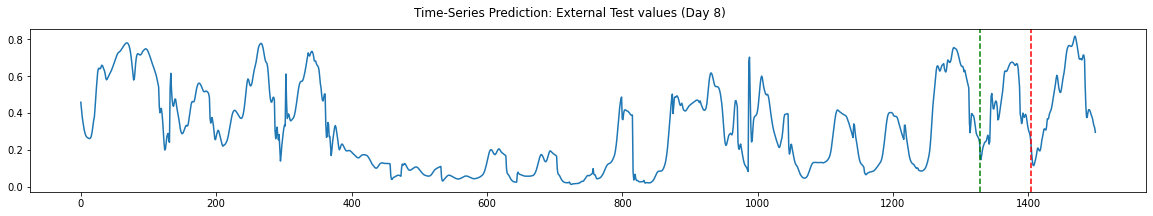

In [ ]:
# Plotting predicted test values including Day 8

lstm.eval()
test_predict = lstm(testX) #Plotting only a subsection to better appreciate the results
if cuda_available:
  test_predict = test_predict.cpu()

test_predict = test_predict.data.numpy()
#train_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,np.transpose([np.transpose(train_predict)])))
test_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,test_predict))

# Set here the start and end index of data in order to zoom in
start_index = len(test_predict)-1500
end_index = len(test_predict)

data_predict = test_predict[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(data_predict)
#plt.axvline(x=(end_index-start_index)-len_external, c='y', linestyle='--')
plt.axvline(x=(end_index-start_index)-len(ext_test_set_x), c='g', linestyle='--')
plt.axvline(x=(end_index-start_index)-96, c='r', linestyle='--')

plt.suptitle('Time-Series Prediction: External Test values (Day 8)')
plt.show()

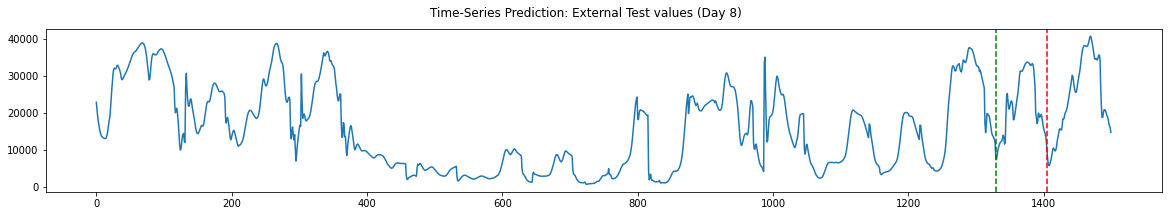

In [ ]:
# Plotting reverse-normalized values for Day 8

norm_values_max = dataset_conversions[dataset_conversions['Type'] == 'Max']['Park_Power_[KW]'].squeeze()
norm_values_min = dataset_conversions[dataset_conversions['Type'] == 'Min']['Park_Power_[KW]'].squeeze()

test_predict_real = test_predict*(norm_values_max-norm_values_min) + norm_values_min

#Plot

# Set here the start and end index of data in order to zoom in
start_index = len(test_predict_real)-1500
end_index = len(test_predict_real)

data_predict = test_predict_real[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(data_predict)
#plt.axvline(x=(end_index-start_index)-len_external, c='y', linestyle='--')
plt.axvline(x=(end_index-start_index)-len(ext_test_set_x), c='g', linestyle='--')
plt.axvline(x=(end_index-start_index)-96, c='r', linestyle='--')

plt.suptitle('Time-Series Prediction: External Test values (Day 8)')
plt.show()

In [ ]:
competition_y = test_predict_real[len(test_predict_real)-96:]
df_competition_y = pd.DataFrame(competition_y)
df_competition_y.tail()

,0
91,18284.832387
92,17219.106505
93,16444.968010
94,15952.681536
95,14700.215021


In [ ]:
#Exporting last 96 predictions for Day 8

df_competition_y.to_csv(drive_path+'WindGurus_Case1_Day8.csv',index=False,header=False)

In [ ]:
# Adding External Set Day 9 to the full dataset

ext_test_set_x = dataset_nwp_day9[['Speed_50m','Speed_100m','Direction_50m','Direction_100m']]
ext_test_set_x = ext_test_set_x.values
len_external = len_external + len(ext_test_set_x)

full_set_x = np.concatenate((full_set_x,ext_test_set_x))
dummy_set_y = np.zeros(shape=full_set_x.shape)

# Assembling sequences for full set
x, y = sliding_windows(full_set_x, dummy_set_y, seq_length_past, seq_length_future)

if cuda_available: # Loading sequences into GPU if possible
  torch.cuda.empty_cache()
  testX = torch.Tensor(np.array(x)).cuda()
  testY = torch.Tensor(np.array(y)).cuda()
else:
  testX = torch.Tensor(np.array(x))
  testY = torch.Tensor(np.array(y))

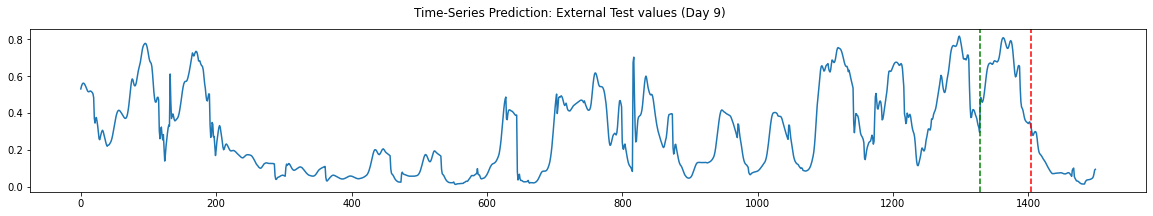

In [ ]:
# Plotting predicted test values including Day 9

lstm.eval()
test_predict = lstm(testX) #Plotting only a subsection to better appreciate the results
if cuda_available:
  test_predict = test_predict.cpu()

test_predict = test_predict.data.numpy()
#train_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,np.transpose([np.transpose(train_predict)])))
test_predict = np.vstack((np.empty((seq_length_past,1))*np.nan,test_predict))

# Set here the start and end index of data in order to zoom in
start_index = len(test_predict)-1500
end_index = len(test_predict)

data_predict = test_predict[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(data_predict)
#plt.axvline(x=(end_index-start_index)-len_external, c='y', linestyle='--')
plt.axvline(x=(end_index-start_index)-len(ext_test_set_x), c='g', linestyle='--')
plt.axvline(x=(end_index-start_index)-96, c='r', linestyle='--')

plt.suptitle('Time-Series Prediction: External Test values (Day 9)')
plt.show()

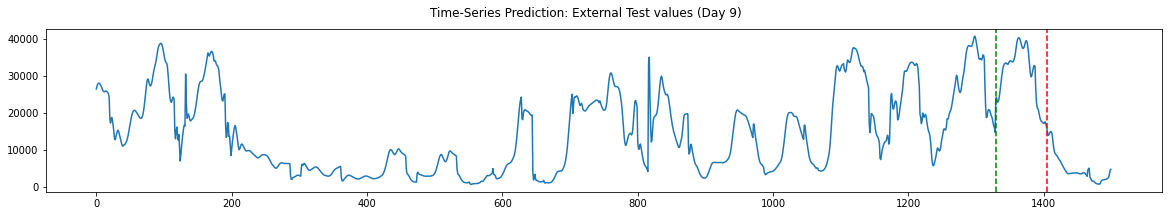

In [ ]:
# Plotting reverse-normalized values for Day 9

norm_values_max = dataset_conversions[dataset_conversions['Type'] == 'Max']['Park_Power_[KW]'].squeeze()
norm_values_min = dataset_conversions[dataset_conversions['Type'] == 'Min']['Park_Power_[KW]'].squeeze()

test_predict_real = test_predict*(norm_values_max-norm_values_min) + norm_values_min

#Plot

# Set here the start and end index of data in order to zoom in
start_index = len(test_predict_real)-1500
end_index = len(test_predict_real)

data_predict = test_predict_real[start_index:end_index]

plt.rcParams["figure.figsize"] = (20,3)

plt.plot(data_predict)
#plt.axvline(x=(end_index-start_index)-len_external, c='y', linestyle='--')
plt.axvline(x=(end_index-start_index)-len(ext_test_set_x), c='g', linestyle='--')
plt.axvline(x=(end_index-start_index)-96, c='r', linestyle='--')

plt.suptitle('Time-Series Prediction: External Test values (Day 9)')
plt.show()

In [ ]:
competition_y = test_predict_real[len(test_predict_real)-96:]
df_competition_y = pd.DataFrame(competition_y)
df_competition_y.tail()

,0
91,2349.574929
92,2692.380162
93,3465.177935
94,4469.462866
95,4668.287929


In [ ]:
#Exporting last 96 predictions for Day 9

df_competition_y.to_csv(drive_path+'WindGurus_Case1_Day9.csv',index=False,header=False)